# Finding the magnetic dipole position with a convolutional neural net

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis


In [2]:
from sklearn.externals import joblib

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2

from glob import glob
from joblib import Parallel, delayed

Using TensorFlow backend.


## Instructions for notebook

The note book can be executed from top to bottom and it generates some output that allows to understand the how the data and models where generated
The outputs are:
  1. data as .h5 file magnet settings as a .json file in '../data/' folder
  2. the model as a .h5 file in '../models/' folder
  3. the notebook as a .html file for future reference in '../html/' folder


Modify `generate_data()` to randomly change the z position and angles in addition to the x and y position.

**2019-01-21**: data for random xy positions with 2000 datapoints and shotnoise level 1, `tag = 'shot_noise_1_xy'`




**show available data sets**

In [4]:
[f.split('/')[-1].split('_train.h5')[0] for f in glob('../data/*train.h5')]

[]

### global notebook setting

In [5]:
calculate_data = True ## if true, data gets generated and saved to disk, if false load previous data from disk

calculate_learning_curve = False

n_train =1000  # number of training examples (calculate_data=True)

n_val = 200  # number of validation examples (calculate_data=True)

**set tag to describe current experiment**

In [6]:
tag = 'shot_noise_1_xyz'

time_stamp = time.strftime('%Y%m%d', time.localtime()) 

## Problem description

we ceate images of a circle with fixed linethickness and varying position and try to get the center position of the circle by fitting to a convolutional neural net

if the data has been generated before jump directly to  [load data](#load_data)



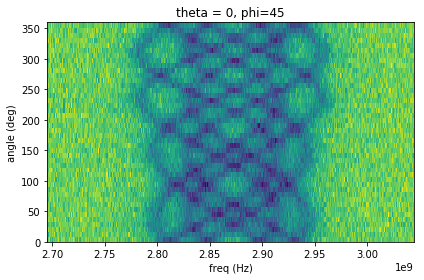

In [7]:
magnet_parameters = {
    'particle_radius':19,
    'nv_radius':73.670,
    'theta_mag': 0,
    'phi_mag': 45,
    'dipole_height':80,
    'shot_noise':1,
    'linewidth':1e7,
    'n_angle':45,
    'n_freq':351,
    'f_min':2.695e9,
    'f_max':3.045e9,
    'avrg_count_rate':1000
}







def create_image(xo, yo, plot_img=False, particle_radius=20, nv_radius=70, theta_mag=0, phi_mag=45,
                                              dipole_height=80, shot_noise=0, linewidth=1e7,
                                              n_angle=60, n_freq=300,
                                              f_min=2.65e9, f_max=3.15e9,
                                              avrg_count_rate=100):
    """
    xo, yo center of the circle
    """
    
    signal = nv_analysis.esr_2D_map_ring_scan(nv_x=xo, nv_y=yo,
                                              particle_radius=particle_radius, nv_radius=nv_radius, theta_mag=theta_mag,
                                              phi_mag=phi_mag,dipole_height=dipole_height, shot_noise=shot_noise,
                                              linewidth=linewidth,n_angle=n_angle, n_freq=n_freq,
                                              f_min=f_min, f_max=f_max,avrg_count_rate=avrg_count_rate,
                                              return_data=True, show_plot=plot_img)


        
    return signal
img = create_image(0, 5, plot_img=True, **magnet_parameters)

In [8]:
with open('../data/parameters_' + tag + '.json', 'w') as outfile:
    json.dump(magnet_parameters, outfile)

In [9]:
nmax = 1000000
c1 = 1000
shot_noise=300
x = np.random.poisson(lam=c1*shot_noise, size=nmax) / shot_noise
# x2 = np.random.poisson(lam=c1, size=nmax) / np.sqrt(shot_noise)
np.std(x)/c1, 1/(np.sqrt(c1)*np.sqrt(shot_noise))

(0.0018242493334128917, 0.0018257418583505537)

## create the test data

In [10]:
def worker_function(parameters, pbar = None):

    img = create_image(**parameters)  # calculate the image
    if pbar:
        pbar.update()  # update the progress
    return img  # return the image


def generate_data(n_data, parameters=None, x_scaler=None, y_scaler=None):
    
    max_displacement = 20 ## maximum offset from the center 
    # positive and negative values
    positions = pd.DataFrame(max_displacement* (np.random.random((n_data, 2))-0.5),
                             columns = ['xo', 'yo'])
    
    positions['dipole_height'] = 20*(np.random.random((n_data)))+60
#     positions['theta_mag'] = 180*(np.random.random((n_data)))
#     positions['phi_mag'] = 90*(np.random.random((n_data)))

    # only positive values
#     positions = pd.DataFrame(max_displacement/2* (np.random.random((n_data, 2))), columns = ['xo', 'yo'])
    

#     pbar = tqdm(total=len(positions))


#     X = []
#     for i, pos in positions.iterrows():
#         params = parameters.copy()
#         params.update(pos.to_dict())
#         X.append(create_image(**params))
#       
#     X = [worker_function(pos.to_dict()) for i, pos in positions.iterrows()]
    X = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(worker_function)({**parameters, **pos.iloc[i].to_dict()})
                                                       for i in tqdm(range(len(positions))))
#     pbar.close()
    X = np.array(X)
    
    
    Y = positions.values

    x_shape = X.shape

    X = X.reshape(X.shape[0], -1)


    # scale inputs and outputs
    if x_scaler is None:
        x_scaler = MinMaxScaler()
    if y_scaler is None:
        y_scaler = MinMaxScaler()

    X = x_scaler.fit_transform(X)
    Y = y_scaler.fit_transform(Y)



    # reshape to add last dimension 1 - for greyscale images
    X = X.reshape(*x_shape, 1)
    
    
    return {'X':X, 'Y': Y, 'x_scaler':x_scaler, 'y_scaler':y_scaler, 'positions' :positions }
    

In [11]:
if calculate_data:

    print('generate training set')
    train_set = generate_data(n_train, parameters=magnet_parameters)

    x_scaler, y_scaler = train_set['x_scaler'], train_set['y_scaler']

    X, Y = train_set['X'], train_set['Y']

0it [00:00, ?it/s]

genrate training set


1000it [04:00,  4.09it/s]


In [20]:
pos = pd.DataFrame(20* (np.random.random((20, 2))-0.5),
                             columns = ['xo', 'yo'])

pos.iloc[0].to_dict(), len(pos)

({'xo': 9.284897867815085, 'yo': 7.00754165460701}, 20)

In [ ]:
if calculate_data:
    print('genrate validation set')
    val_set = generate_data(n_val, x_scaler=x_scaler, y_scaler=y_scaler, parameters=magnet_parameters)


### save the data set to disk

In [36]:
while True:
    filename = '../data/' + tag + '_--type--_{:03d}'.format(i)
    if not os.path.isfile(filename.replace('--type--', 'train')+'.h5'):
        break
    else:
        i += 1
print(filename)

../data/shot_noise_1_xyz_--type--_001


In [30]:
if calculate_data:
    print('saving the validation data (' + tag + ')')
    i = 0
    hf = h5py.File(filename.replace('--type--', 'validation')+'.h5', 'w')
    hf.create_dataset("X",data=val_set['X'])
    hf.create_dataset("Y",data =val_set['Y'])
    hf.close()

saving the validation data (shot_noise_1_xyz)


NameError: name 'val_set' is not defined

In [ ]:
if calculate_data:

    print('saving the scalers data (' + tag + ')')
    joblib.dump(train_set['x_scaler'], filename.replace('-c_scaler', 'validation') + '.save') 
    joblib.dump(train_set['y_scaler'], filename.replace('-y_scaler', 'validation') + '.save') 


    print('saving the training data (' + tag + ')')

    hf = h5py.File(filename.replace('--type--', 'train')+'.h5', 'w')
    hf.create_dataset("X",data=train_set['X'])
    hf.create_dataset("Y",data =train_set['Y'])
    hf.close()

## reading the data 
<a id="load_data"></a>

In [ ]:
with open('../data/parameters_' + tag + '.json', 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

In [ ]:
hf = h5py.File('../data/' + tag + '_validation.h5', 'r')
val_set = {k: np.array(hf.get(k)) for k in hf.keys()}
hf.close()

In [ ]:
hf = h5py.File('../data/' + tag + '_train.h5', 'r')
train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
train_set['x_scaler'] = joblib.load('../data/' + tag + '_x_scaler.save') 
train_set['y_scaler'] = joblib.load('../data/' + tag + '_y_scaler.save') 
hf.close()

In [ ]:
X, Y = train_set['X'], train_set['Y']

In [ ]:
x_scaler, y_scaler = train_set['x_scaler'], train_set['y_scaler']

## making the model

In [38]:
# define base model
def baseline_model():
    
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))

#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    
#     model.add(Dense(64, input_dim=64,kernel_regularizer=regularizers.l2(0.01))
    
    
    
    model.add(Flatten())
    model.add(Dense(Y.shape[1]))
#     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model
              
              
              
              
# define base model
# def baseline_model():
    
#     #create model
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# #     model.add(Dropout(0.5))
#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
# #     model.add(Conv2D(2, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
# #     
    
#     model.add(Flatten())
#     model.add(Dense(100))
#     model.add(Dropout(0.5))
#     model.add(Dense(Y.shape[1]))
# #     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#     return model
              


In [39]:
model = baseline_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 349, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 174, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 58464)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 175395    
Total params: 175,555
Trainable params: 175,555
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X.shape, val_set['X'].shape

## train the model - using Keras API

In [ ]:
model = baseline_model()

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
    LossHistory()
]

history = model.fit(X,Y, epochs=32, batch_size=32,verbose=1, validation_split=0.2, callbacks=callbacks)
# history = model.fit(X[0:200],Y[0:200], epochs=100, batch_size=32,verbose=1, validation_data=(val_set['X'], val_set['Y']))

In [40]:
?model.fit

In [ ]:
for value in ['val_mean_squared_error', 'mean_squared_error']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

In [ ]:
val_set['X'].min(),val_set['X'].max()

### save the model

In [ ]:
model.save('../models/'+tag+'_model.h5')
print('../models/' + time_stamp + '_' +tag+'_model.h5 saved')

## learning curve
we use the keras wrapper for sklearn to be able to use the sklearn function

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    fig = plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=2)
#     exploit_incremental_learning=True)
    train_scores_mean = np.abs(np.mean(train_scores, axis=1))  # when the score is a negative function
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.abs(np.mean(test_scores, axis=1))  # when the score is a negative function
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return fig, {'train_scores_mean':train_scores_mean,
                 'train_scores_std':train_scores_std,
                 'test_scores_mean':test_scores_mean,
                'test_scores_std':test_scores_std}






In [ ]:
train_sizes= [int(x) for x in 2**np.arange(4,11)]
train_sizes

In [ ]:
%%time
if calculate_learning_curve:
    
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    model_reg = KerasRegressor(build_fn=baseline_model, epochs=16, batch_size=32, verbose=0)

    fig, data_learn = plot_learning_curve(model_reg, 'learning curve', X, Y, cv=cv, train_sizes=train_sizes)
    
    fig.savefig('../images/'+tag+'_learning_curve.jpg')

In [ ]:
# # plt.loglog(train_sizes, -data_learn['train_scores_mean'])
# # plt.loglog(train_sizes, -data_learn['test_scores_mean'])

# train_scores_mean = -data_learn['train_scores_mean']
# train_scores_std = data_learn['train_scores_std']
# test_scores_mean = -data_learn['test_scores_mean']
# test_scores_std = data_learn['test_scores_std']

# fig = plt.figure()
# plt.grid()

# plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")


# plt.legend(loc="best")
# plt.xlabel('number of training data')
# plt.ylabel('mean squared error')

# fig.savefig('../images/'+tag+'_learning_curve.jpg')

## show how well the model fits
### on the training data

In [ ]:
n_max = 20

In [ ]:
Y_predict = model.predict(X[0:n_max])

#### scaled outputs

In [ ]:
plt.scatter(Y[:n_max, 0], Y[:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

In [ ]:
Y.shape

In [ ]:
for i in range(10):

    plt.plot([Y[i, 0], Y_predict[i, 0]], [Y[i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

#### original outputs

In [ ]:
Y_real = y_scaler.inverse_transform(Y[0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

In [ ]:
plt.plot(Y_real-Y_pred_real, '+')

In [ ]:

n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

x_shape = X[0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(X[0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    if Y_real.shape[1]==2:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}'.format(*Y_real[i]))
    if Y_real.shape[1]==3:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}, z={:0.2f}'.format(*Y_real[i]))
    elif Y_real.shape[1]==5:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}, z={:0.2f}, t={:0.2f}, p={:0.2f}'.format(*Y_real[i]))
    # and create the image
    img = create_image(*Y_real[i, 0:2], **magnet_parameters)
    ax[1].pcolor(frequencies, angle, img)
    if Y_real.shape[1]==2:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}'.format(*Y_pred_real[i]))
    if Y_real.shape[1]==3:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}, z={:0.2f}'.format(*Y_pred_real[i]))
    elif Y_real.shape[1]==5:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}, z={:0.2f}, t={:0.2f}, p={:0.2f}'.format(*Y_pred_real[i]))
    plt.tight_layout()

    

### on the validation data

In [ ]:
Y_predict = model.predict(val_set['X'][0:n_max])

#### scaled outputs

In [ ]:
plt.scatter(val_set['Y'][:n_max, 0], val_set['Y'][:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

In [ ]:
for i in range(10):

    plt.plot([val_set['Y'][i, 0], Y_predict[i, 0]], [val_set['Y'][i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

#### original outputs

In [ ]:
Y_real = y_scaler.inverse_transform(val_set['Y'][0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

In [ ]:
plt.plot(Y_real-Y_pred_real, '+')

In [ ]:

n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

x_shape = val_set['X'][0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(val_set['X'][0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    
    if Y_real.shape[1]==2:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}'.format(*Y_real[i]))
    elif Y_real.shape[1]==3:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}, z={:0.2f}'.format(*Y_real[i]))
    elif Y_real.shape[1]==5:
        ax[0].set_title('real\n x={:0.2f}, y={:0.2f}, z={:0.2f}, t={:0.2f}, p={:0.2f}'.format(*Y_real[i]))

    # and create the image
    img = create_image(*Y_pred_real[i, 0:2], **magnet_parameters)
    ax[1].pcolor(frequencies, angle, img)
    if Y_real.shape[1]==2:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}'.format(*Y_pred_real[i]))
    elif Y_real.shape[1]==3:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}, z={:0.2f}'.format(*Y_pred_real[i]))
    elif Y_real.shape[1]==5:
        ax[1].set_title('reconstructed\n x={:0.2f}, y={:0.2f}, z={:0.2f}, t={:0.2f}, p={:0.2f}'.format(*Y_pred_real[i]))

    
    plt.tight_layout()
    

# Save current notebook as HTML

In [ ]:
from IPython.display import Javascript

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [ ]:
%%time
import time
save_notebook()
time.sleep(3)
current_file = 'CNN - reconstruct magnet position from esr spectra.ipynb'
output_file = '../html/' + time_stamp + '_' + tag + '.html' 
output_HTML(current_file, output_file)
print(output_file)

# continue training

In [ ]:
from keras.models import load_model
model = load_model('../models/'+tag+'_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('../models/'+tag+'_model.h5')

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
    LossHistory()
]

history = model.fit(X,Y, epochs=32, batch_size=32,verbose=1,
                    validation_split=0.2, callbacks=callbacks)
# history = model.fit(X[0:200],Y[0:200], epochs=100, batch_size=32,verbose=1, validation_data=(val_set['X'], val_set['Y']))

In [ ]:
model.weights

In [ ]:
history.history